# Weighted Dataset Model

- Train: AnyAgree_train
- Test: 75Agree_test

# TODO

- cv

In [1]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from transformers import get_scheduler
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
import torch
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import get_scheduler
from torch.optim import AdamW
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
import numpy as np

/opt/anaconda3/envs/CAA02/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Step 1: Read the data

In [2]:
# load the training and test datasets
df_train = pd.read_csv('data/AnyAgree_train.csv')
df_test = pd.read_csv('data/75Agree_test.csv')


print(f"Agreements in training set: {df_train['agreement'].unique()}")
df_train.head(3)

Agreements in training set: ['66Agree' '50Agree' '75Agree' 'AllAgree']


,sentence,label,agreement
0,Technopolis plans to develop in stages an area...,neutral,66Agree
1,The international electronic industry company ...,negative,50Agree
2,With the new production plant the company woul...,positive,75Agree


In [3]:
# label encoders
label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {v: k for k, v in label2id.items()}

# label encoding
df_train["label"] = df_train["label"].map(label2id)
df_test["label"] = df_test["label"].map(label2id)

# balance the training set: undersample to minority class
df_train = df_train.groupby("label").apply(lambda x: x.sample(df_train["label"].value_counts().min())).reset_index(drop=True)
df_train.value_counts("label")

/var/folders/sz/96b_h5gn3y33k0c7jsvrstmm0000gn/T/ipykernel_1109/2547942190.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train = df_train.groupby("label").apply(lambda x: x.sample(df_train["label"].value_counts().min())).reset_index(drop=True)


label
0    520
1    520
2    520
Name: count, dtype: int64

### Step 2: Create the weighted pipeline

In [4]:
# define the datasets class (with or without weights)
class WeightedTextDataset(Dataset):
    def __init__(self, df, tokenizer, weight_map):
        texts = df["sentence"].tolist()
        labels = df["label"].tolist()
        weight_classes = df["agreement"].tolist()
        self.encodings = tokenizer(texts, truncation=True, padding="max_length", max_length=128)
        self.labels = labels
        self.weights = [weight_map[w] for w in weight_classes]

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        item['weights'] = torch.tensor(self.weights[idx], dtype=torch.float)
        return item

    def __len__(self):
        return len(self.labels)
    
class WeightlessTextDataset(Dataset):
    def __init__(self, df, tokenizer):
        texts = df["sentence"].tolist()
        labels = df["label"].tolist()

        self.encodings = tokenizer(texts, truncation=True, padding="max_length", max_length=128)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# define the tokenizer    
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# define the weight map

**Weight Map**

The ideia is that the higher the agreement level, the higher the weight, so the model will focus more on the samples with higher agreement.

But the weights should also take into account the number of samples in each agreement level so the cost function can be compared to a weightless dataset.

With that in mind, the weight map should be dynamically calculated based on the number of samples in each agreement level following this formula:

$\ $

Let $a_1, a_2, \ldots, a_k$ be the raw agreement scores for each class (e.g., 0.5, 0.66, 0.75, 1.0)

Let $ n_i $ be the number of samples in class $ i $, and $ N = \sum_{i=1}^k n_i $

Let $ p_i $ be the softmax weight for class $ i $, and $ w_i $ be the final weight for class $ i $

$$
w_i = \text{scale} \cdot p_i = \left( \frac{N}{\sum_{j=1}^k n_j \cdot p_j} \right) \cdot  \left( \frac{e^{a_i}}{\sum_{j=1}^k e^{a_j}} \right)
$$

In [5]:
def get_weight_map(df):
    """
    Compute a weight map using softmax-normalized agreement scores, scaled so the mean weight is 1.
    """
    a_i = {
        "50Agree": 0.50,
        "66Agree": 0.66,
        "75Agree": 0.75,
        "AllAgree": 1.00
    }
    n_i = {agreement: df['agreement'].value_counts().get(agreement, 0) for agreement in a_i.keys()}
    N = len(df)

    # compute softmax weights (p_i)
    p_i = {agreement: np.exp(a_i[agreement]) for agreement in a_i}
    p_i = {agreement: value/ sum(p_i.values()) for agreement, value in p_i.items()}

    # compute scale (scale)
    scale = N / sum(n_i[agreement] * p_i[agreement] for agreement in p_i)

    # compute weight map
    weight_map = {agreement: scale * p_i[agreement] for agreement in p_i}

    # return the weight map
    return weight_map

### Step 3: Tune the hyperparameters

In [6]:
# prepare for cv
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# set random search area
def get_hyperparameters():
    return {
        "num_train_epochs": int(np.random.choice([1, 2, 3, 4, 5])),
        "learning_rate": float(np.random.choice([1e-5, 1e-4, 1e-3, 1e-2])),
        "weight_decay": float(np.random.choice([0.0, 0.01, 0.05, 0.1, 0.5])),
    }

try:
    all_results = pd.read_csv("model BERT (3).csv")
except FileNotFoundError:
    all_results = pd.DataFrame(columns=["num_train_epochs", "learning_rate", "weight_decay", "eval_loss"])

# start the hyperparameter tuning
for _ in range(120): #range(25)
    current_hyperparameters = get_hyperparameters()
    current_hyperparameters_eval_loss = 0
    current_results = {"num_train_epochs": [], "learning_rate": [], "weight_decay": [], "eval_loss": []}

    # make sure the hyperparameters are not already evaluated
    mask = (
        (all_results['num_train_epochs'] == current_hyperparameters['num_train_epochs']) &
        (all_results['learning_rate'] == current_hyperparameters['learning_rate']) &
        (all_results['weight_decay'] == current_hyperparameters['weight_decay'])
    )
    if mask.any():
        print("Hyperparameters already evaluated, skipping...")
        continue
    else:
        print(f"Evaluating hyperparameters: {current_hyperparameters}")
    
    # tuning hyperparameters
    for fold, (train_idx, val_idx) in enumerate(skf.split(df_train, df_train["label"])):

        # get the folds
        df_fold_train = df_train.iloc[train_idx]
        df_fold_val = df_train.iloc[val_idx]

        # dataset preparation for the model
        train_dataset = WeightedTextDataset(df_fold_train, tokenizer, get_weight_map(df_fold_train))
        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

        val_dataset = WeightedTextDataset(df_fold_val, tokenizer, get_weight_map(df_fold_val))
        val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

        # define the model
        device = torch.device("cpu")
        model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3, id2label=id2label, label2id=label2id)
        model.to(device)

        # setup the otimizer and scheduler
        optimizer = AdamW(model.parameters(),
                        lr=current_hyperparameters["learning_rate"],
                        weight_decay=current_hyperparameters["weight_decay"])

        lr_scheduler = get_scheduler("linear", optimizer=optimizer,
                                    num_warmup_steps=0,
                                    num_training_steps=len(train_loader) * current_hyperparameters["num_train_epochs"])
            

        # training the model
        for epoch in range(current_hyperparameters["num_train_epochs"]):
            model.train()
            for batch in tqdm(train_loader):
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(input_ids=batch["input_ids"],
                                attention_mask=batch["attention_mask"],
                                labels=batch["labels"])
                logits = outputs.logits

                per_sample_loss = torch.nn.functional.cross_entropy(
                    logits, batch["labels"], reduction='none')
                weighted_loss = (per_sample_loss * batch["weights"]).mean()

                optimizer.zero_grad()
                weighted_loss.backward()
                optimizer.step()
                lr_scheduler.step()

        # weighted validation loss
        model.eval()
        val_losses = []
        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(input_ids=batch["input_ids"],
                                attention_mask=batch["attention_mask"])
                logits = outputs.logits
                loss = torch.nn.functional.cross_entropy(logits, batch["labels"], reduction='none')
                weighted_loss = (loss * batch["weights"]).mean()
                val_losses.append(weighted_loss.item())
        val_mean = sum(val_losses) / len(val_losses)
        print(f"Fold {fold + 1}/{skf.n_splits}, Validation Loss: {val_mean:.4f}")
        
        # update the evaluation loss
        current_hyperparameters_eval_loss += val_mean

    # update the results dataframe
    current_results["num_train_epochs"].append(current_hyperparameters["num_train_epochs"])
    current_results["learning_rate"].append(current_hyperparameters["learning_rate"])
    current_results["weight_decay"].append(current_hyperparameters["weight_decay"])
    current_results["eval_loss"].append(current_hyperparameters_eval_loss / skf.n_splits)
    all_results = pd.concat([all_results, pd.DataFrame(current_results)], ignore_index=True)
    all_results.to_csv("model BERT (3).csv", index=False)

"Hyperparameter tuning completed. Results saved to model BERT (3).csv."

Evaluating hyperparameters: {'num_train_epochs': 5, 'learning_rate': 0.0001, 'weight_decay': 0.1}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:57<00:00,  2.28s/it]


Fold 1/5, Validation Loss: 0.6162


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:52<00:00,  2.21s/it]


Fold 2/5, Validation Loss: 0.5310


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:53<00:00,  2.22s/it]


Fold 3/5, Validation Loss: 0.4369


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:54<00:00,  2.24s/it]


Fold 4/5, Validation Loss: 0.6458


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:54<00:00,  2.24s/it]


Fold 5/5, Validation Loss: 0.6316
Evaluating hyperparameters: {'num_train_epochs': 2, 'learning_rate': 0.01, 'weight_decay': 0.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:52<00:00,  2.22s/it]


Fold 1/5, Validation Loss: 1.1091


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [03:04<00:00,  2.37s/it]


Fold 2/5, Validation Loss: 1.1141


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:58<00:00,  2.29s/it]


Fold 3/5, Validation Loss: 1.1199


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:57<00:00,  2.27s/it]


Fold 4/5, Validation Loss: 1.1161


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:56<00:00,  2.27s/it]


Fold 5/5, Validation Loss: 1.1263
Evaluating hyperparameters: {'num_train_epochs': 1, 'learning_rate': 0.01, 'weight_decay': 0.05}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:55<00:00,  2.25s/it]


Fold 1/5, Validation Loss: 1.1396


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:55<00:00,  2.25s/it]


Fold 2/5, Validation Loss: 1.2049


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:57<00:00,  2.28s/it]


Fold 3/5, Validation Loss: 1.1308


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:56<00:00,  2.26s/it]


Fold 4/5, Validation Loss: 1.1216


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:57<00:00,  2.28s/it]


Fold 5/5, Validation Loss: 1.2208
Evaluating hyperparameters: {'num_train_epochs': 2, 'learning_rate': 0.01, 'weight_decay': 0.05}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:56<00:00,  2.26s/it]


Fold 1/5, Validation Loss: 1.1133


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:56<00:00,  2.26s/it]


Fold 2/5, Validation Loss: 1.1820


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:55<00:00,  2.25s/it]


Fold 3/5, Validation Loss: 1.1040


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:55<00:00,  2.25s/it]


Fold 4/5, Validation Loss: 1.0972


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:54<00:00,  2.24s/it]


Fold 5/5, Validation Loss: 1.1160
Evaluating hyperparameters: {'num_train_epochs': 3, 'learning_rate': 1e-05, 'weight_decay': 0.1}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:55<00:00,  2.25s/it]


Fold 1/5, Validation Loss: 0.5115


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:56<00:00,  2.26s/it]


Fold 2/5, Validation Loss: 0.4826


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:56<00:00,  2.26s/it]


Fold 3/5, Validation Loss: 0.5485


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:55<00:00,  2.25s/it]


Fold 4/5, Validation Loss: 0.5174


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:56<00:00,  2.26s/it]


Fold 5/5, Validation Loss: 0.5552
Evaluating hyperparameters: {'num_train_epochs': 5, 'learning_rate': 0.01, 'weight_decay': 0.05}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:55<00:00,  2.25s/it]


Fold 1/5, Validation Loss: 1.1092


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:56<00:00,  2.26s/it]


Fold 2/5, Validation Loss: 1.1099


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:55<00:00,  2.26s/it]


Fold 3/5, Validation Loss: 1.1091


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:57<00:00,  2.27s/it]


Fold 4/5, Validation Loss: 1.1146


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:56<00:00,  2.27s/it]


Fold 5/5, Validation Loss: 1.1138
Evaluating hyperparameters: {'num_train_epochs': 5, 'learning_rate': 0.001, 'weight_decay': 0.5}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:55<00:00,  2.25s/it]


Fold 1/5, Validation Loss: 1.0955


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:56<00:00,  2.26s/it]


Fold 2/5, Validation Loss: 1.1010


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:55<00:00,  2.25s/it]


Fold 3/5, Validation Loss: 1.1036


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:55<00:00,  2.25s/it]


Fold 4/5, Validation Loss: 1.0969


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:55<00:00,  2.25s/it]


Fold 5/5, Validation Loss: 1.0996
Evaluating hyperparameters: {'num_train_epochs': 1, 'learning_rate': 0.0001, 'weight_decay': 0.01}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:56<00:00,  2.26s/it]


Fold 1/5, Validation Loss: 0.4675


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:56<00:00,  2.26s/it]


Fold 2/5, Validation Loss: 0.3923


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:55<00:00,  2.25s/it]


Fold 3/5, Validation Loss: 0.4658


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:56<00:00,  2.26s/it]


Fold 4/5, Validation Loss: 0.5676


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:56<00:00,  2.27s/it]


Fold 5/5, Validation Loss: 0.4237
Evaluating hyperparameters: {'num_train_epochs': 4, 'learning_rate': 0.01, 'weight_decay': 0.5}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:56<00:00,  2.26s/it]


Fold 1/5, Validation Loss: 1.1000


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:55<00:00,  2.24s/it]


Fold 2/5, Validation Loss: 1.1140


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:56<00:00,  2.26s/it]


Fold 3/5, Validation Loss: 1.1279


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:55<00:00,  2.25s/it]


Fold 4/5, Validation Loss: 1.0974


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:55<00:00,  2.25s/it]


Fold 5/5, Validation Loss: 1.1075
Evaluating hyperparameters: {'num_train_epochs': 1, 'learning_rate': 0.01, 'weight_decay': 0.5}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:55<00:00,  2.25s/it]


Fold 1/5, Validation Loss: 1.1160


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:56<00:00,  2.26s/it]


Fold 2/5, Validation Loss: 1.1183


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:55<00:00,  2.25s/it]


Fold 3/5, Validation Loss: 1.1020


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:55<00:00,  2.25s/it]


Fold 4/5, Validation Loss: 1.1337


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:55<00:00,  2.25s/it]


Fold 5/5, Validation Loss: 1.1557
Evaluating hyperparameters: {'num_train_epochs': 4, 'learning_rate': 0.001, 'weight_decay': 0.05}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:55<00:00,  2.25s/it]


Fold 1/5, Validation Loss: 1.0957


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:55<00:00,  2.25s/it]


Fold 2/5, Validation Loss: 1.1013


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:56<00:00,  2.26s/it]


Fold 3/5, Validation Loss: 1.1016


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:55<00:00,  2.25s/it]


Fold 4/5, Validation Loss: 1.0982


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:55<00:00,  2.25s/it]


Fold 5/5, Validation Loss: 1.0987
Evaluating hyperparameters: {'num_train_epochs': 4, 'learning_rate': 0.01, 'weight_decay': 0.05}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:56<00:00,  2.26s/it]


Fold 1/5, Validation Loss: 1.1051


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:55<00:00,  2.25s/it]


Fold 2/5, Validation Loss: 1.1034


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [03:00<00:00,  2.32s/it]


Fold 3/5, Validation Loss: 1.1173


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [03:02<00:00,  2.34s/it]


Fold 4/5, Validation Loss: 1.1138


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 78/78 [02:55<00:00,  2.25s/it]


Fold 5/5, Validation Loss: 1.1009
Evaluating hyperparameters: {'num_train_epochs': 4, 'learning_rate': 1e-05, 'weight_decay': 0.1}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 86%|████████▌ | 67/78 [02:34<00:25,  2.30s/it]


KeyboardInterrupt: 

In [7]:
all_results = all_results.sort_values(by="eval_loss").reset_index(drop=True)
all_results.to_csv("model BERT (3).csv", index=False)

all_results.head(3)

,num_train_epochs,learning_rate,weight_decay,eval_loss
0,1,0.0001,0.10,0.462535
1,1,0.0001,0.01,0.463366
2,4,0.0001,0.50,0.514014


### Step 4: Train the model with the best hyperparameters

In [8]:
best_hyperparameters = all_results.iloc[0]
print(f"Best hyperparameters found in {all_results.shape[0]} tested combinations:")
print(f"Num train epochs: {best_hyperparameters['num_train_epochs']}")
print(f"Learning rate: {best_hyperparameters['learning_rate']}")
print(f"Weight decay: {best_hyperparameters['weight_decay']}")

Best hyperparameters found in 18 tested combinations:
Num train epochs: 1.0
Learning rate: 0.0001
Weight decay: 0.1


In [9]:
# prepare the datasets
train_dataset = WeightedTextDataset(df_train, tokenizer, get_weight_map(df_train))
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = WeightlessTextDataset(df_test, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
# define the model
device = torch.device("cpu")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3, id2label=id2label, label2id=label2id)
model.to(device)

# setup the otimizer and scheduler
optimizer = AdamW(model.parameters(),
                  lr=float(best_hyperparameters["learning_rate"]),
                  weight_decay=float(best_hyperparameters["weight_decay"]))

lr_scheduler = get_scheduler("linear", optimizer=optimizer,
                             num_warmup_steps=0,
                             num_training_steps=len(train_loader) * int(best_hyperparameters["num_train_epochs"]))

# training the model with loss tracking
train_loss_per_epoch = []
val_loss_per_epoch = []

for epoch in range(int(best_hyperparameters["num_train_epochs"])):
    model.train()
    epoch_losses = []
    for batch in tqdm(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(input_ids=batch["input_ids"],
                        attention_mask=batch["attention_mask"],
                        labels=batch["labels"])
        logits = outputs.logits

        per_sample_loss = torch.nn.functional.cross_entropy(
            logits, batch["labels"], reduction='none')
        weighted_loss = (per_sample_loss * batch["weights"]).mean()

        optimizer.zero_grad()
        weighted_loss.backward()
        optimizer.step()
        lr_scheduler.step()

        epoch_losses.append(weighted_loss.item())

    mean_train_loss = sum(epoch_losses) / len(epoch_losses)
    train_loss_per_epoch.append(mean_train_loss)
    print(f"Epoch {epoch+1}, Train Weighted Loss: {mean_train_loss:.4f}")

    # weightless validation loss for the test set
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(input_ids=batch["input_ids"],
                            attention_mask=batch["attention_mask"])
            logits = outputs.logits
            loss = torch.nn.functional.cross_entropy(logits, batch["labels"], reduction='mean')
            val_losses.append(loss.item())

    val_mean = sum(val_losses) / len(val_losses)
    val_loss_per_epoch.append(val_mean)
    print(f"Epoch {epoch+1}, Val Unweighted Loss: {val_mean:.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 27%|██▋       | 26/98 [01:00<02:45,  2.30s/it]

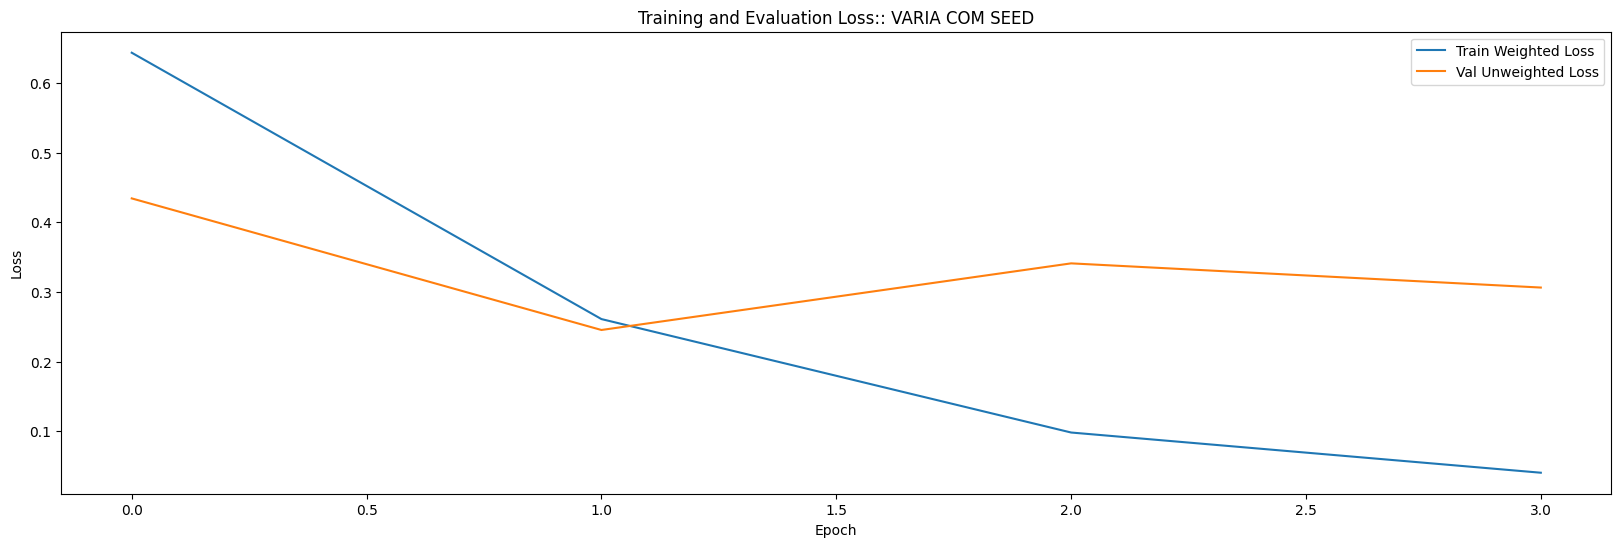

In [ ]:
# show the learning curves
plt.figure(figsize=(20, 6))
plt.plot(train_loss_per_epoch, label='Train Weighted Loss')
plt.plot(val_loss_per_epoch, label='Val Unweighted Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Evaluation Loss:: VARIA COM SEED")
plt.show()

### Step 5: Evaluate the model


=== Classification Report (Partial Train (weightless 75% Agreement)) ===
              precision    recall  f1-score   support

    negative       0.78      1.00      0.88       336
     neutral       0.99      0.92      0.95      1717
    positive       0.90      0.93      0.91       709

    accuracy                           0.93      2762
   macro avg       0.89      0.95      0.91      2762
weighted avg       0.94      0.93      0.93      2762



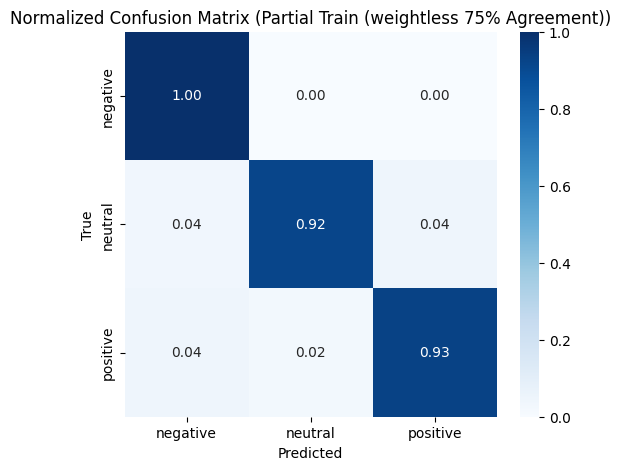


=== Classification Report (Test) ===
              precision    recall  f1-score   support

    negative       0.75      0.98      0.85        84
     neutral       0.98      0.91      0.94       429
    positive       0.86      0.88      0.87       178

    accuracy                           0.91       691
   macro avg       0.86      0.92      0.88       691
weighted avg       0.92      0.91      0.91       691



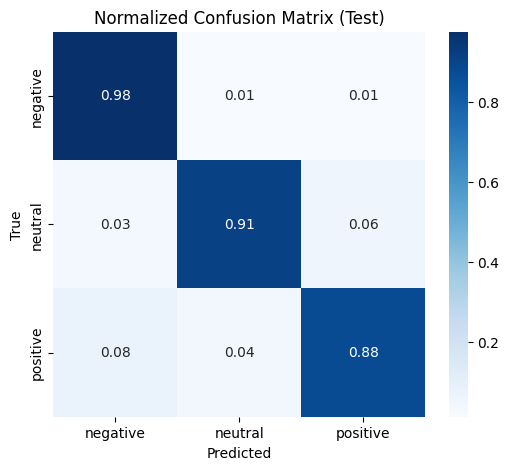

In [ ]:
def evaluate_dataset(dataset, split_name):
    model.eval()
    all_preds = []
    all_labels = []

    dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(input_ids=batch["input_ids"],
                            attention_mask=batch["attention_mask"])
            preds = torch.argmax(outputs.logits, dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch["labels"].cpu().numpy())

    print(f"\n=== Classification Report ({split_name}) ===")
    print(classification_report(all_labels, all_preds, target_names=["negative", "neutral", "positive"]))

    cm = confusion_matrix(all_labels, all_preds, normalize='true')
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=["negative", "neutral", "positive"],
                yticklabels=["negative", "neutral", "positive"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Normalized Confusion Matrix ({split_name})")
    plt.show()


semi_train_df = pd.read_csv('data/75Agree_train.csv')
semi_train_df["label"] = semi_train_df["label"].map(label2id)
semi_train_dataset = WeightlessTextDataset(semi_train_df, tokenizer)

df_test = pd.read_csv('data/75Agree_test.csv')
df_test["label"] = df_test["label"].map(label2id)
test_dataset = WeightlessTextDataset(df_test, tokenizer)

# evaluate the model on the training and test datasets
evaluate_dataset(semi_train_dataset, "Partial Train (weightless 75% Agreement)")
evaluate_dataset(test_dataset, "Test")